In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.utils import Sequence

Using TensorFlow backend.


In [3]:
def read_class():
    CLASS_NAME = []
    with open('./classes.txt', 'r') as class_file:
        for i, line in enumerate(class_file):
            line = line.rstrip('\n')
            CLASS_NAME.append(line)
    return CLASS_NAME

In [4]:
""" Hyperparameters defined here """
CLASS_NAME = read_class()
NUM_CLASS = len(CLASS_NAME)
TRAIN_DF  = []
TEST_DF   = []
DATA_PATH = '/Volumes/JS/QuickDraw/'
NUM_VALID = 80

In [8]:
def split_dataset():
    all_npy_path = DATA_PATH + 'data_split/train_simplified'
    train_npy_path = DATA_PATH + 'data_split/train_set'
    valid_npy_path = DATA_PATH + 'data_split/valid_set'

    for name in CLASS_NAME:
        name = name.replace('_', ' ')
        df = pd.read_csv(DATA_PATH + 'train_simplified/%s.csv' % name)
        key_id = df['key_id'].values.astype(np.int64)
        np.random.shuffle(key_id)

        n = len(key_id)
        n_valid = NUM_VALID
        n_train = n - n_valid

        np.save(all_npy_path + '/%s.npy' % name, key_id)
        np.save(train_npy_path + '/%s.npy' % name, key_id[:n_train])
        np.save(valid_npy_path + '/%s.npy' % name, key_id[n_train:])
    print('Finish dataset split.')

In [49]:
split_dataset()

In [5]:
class Struct(object):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
        
def drawing_to_image(drawing, H, W):

    point=[]
    time =[]
    for t,(x,y) in enumerate(drawing):
        point.append(np.array((x,y),np.float32).T)
        time.append(np.full(len(x),t))

    point = np.concatenate(point).astype(np.float32)
    time  = np.concatenate(time ).astype(np.int32)

    image  = np.full((H,W,3),0,np.uint8)
    x_max = point[:,0].max()
    x_min = point[:,0].min()
    y_max = point[:,1].max()
    y_min = point[:,1].min()
    w = x_max-x_min
    h = y_max-y_min
    #print(w,h)

    s = max(w,h)
    norm_point = (point-[x_min,y_min])/s
    norm_point = (norm_point-[w/s*0.5,h/s*0.5])*max(W,H)*0.85
    norm_point = np.floor(norm_point + [W/2,H/2]).astype(np.int32)

    T = time.max()+1
    for t in range(T):
        p = norm_point[time==t]
        x,y = p.T
        image[y,x]=255
        N = len(p)
        for i in range(N-1):
            x0,y0 = p[i]
            x1,y1 = p[i+1]
            cv2.line(image,(x0,y0),(x1,y1),(255,255,255),1,cv2.LINE_AA)

    return image


def null_augment(drawing, label, index):
    cache = Struct(drawing = drawing.copy(), label = label, index=index)
    image = drawing_to_image(drawing, 64, 64)
    return image, label, cache

def time_to_str(t, mode='min'):
    if mode=='min':
        t  = int(t)/60
        hr = t//60
        min = t%60
        return '%2d hr %02d min'%(hr,min)

    elif mode=='sec':
        t   = int(t)
        min = t//60
        sec = t%60
        return '%2d min %02d sec'%(min,sec)

In [54]:
class ImageConvertor(Sequence):
    def __init__(self, 
                 data, 
                 split='train_set', 
                 batch_size=16, 
                 augment=null_augment, 
                 mode='simplified', 
                 shuffle=True,
                 debug=False):
        """ data: could be 'train' or 'test', the former used to get splited dataset train_set or valid_set, 
                  the latter used to get the TEST_DF
        """
        assert mode in ['simplified', 'raw']
        start = timer()
        
        self.data = data
        self.split = split
        self.batch_size = batch_size
        self.augment = augment
        self.mode = mode 
        self.H, self.W = 64, 64

        self.df     = []
        self.id     = []
        
        if not debug:
            if self.data == 'train':
                TRAIN_DF = []
                # countrycode, drawing, key_id, recognized, timestamp, word

                if TRAIN_DF == []:
                    for i, name in enumerate(CLASS_NAME):
                        print('\r\t load df   :  %3d/%3d %24s  %s'%(i, NUM_CLASS, name,time_to_str((timer() - start),'sec')),
                              end='',flush=True)
                        name = name.replace('_', ' ')

                        df = pd.read_csv(DATA_PATH + 'train_%s/%s.csv'%(self.mode, name))
                        TRAIN_DF.append(df)
                    print('\n')
                self.df = TRAIN_DF

                for i, name in enumerate(CLASS_NAME):
                    print('\r\t load split:  %3d/%3d %24s  %s'%(i, NUM_CLASS,name,time_to_str((timer() - start),'sec')), 
                          end='', flush=True)
                    name = name.replace('_', ' ')
                    df = TRAIN_DF[i]
                    key_id = np.load(DATA_PATH + 'data_split/%s/%s.npy'%(self.split,name))
                    label = np.full(len(key_id), i, dtype=np.int64)
                    drawing_id = df.loc[df['key_id'].isin(key_id)].index.values
                    self.id.append(np.vstack([label, drawing_id, key_id]).T)
                self.id = np.concatenate(self.id)
        else:
            if self.data =='train':
                TRAIN_DF = []
                if TRAIN_DF == []:
                    name = 'angel'
                    print('\r\t load df   :  %3d/%3d %24s  %s'%(6, NUM_CLASS, name,time_to_str((timer() - start),'sec')),
                          end='',flush=True)
                    df = pd.read_csv(DATA_PATH + 'train_%s/%s.csv' % (self.mode, name))
                    TRAIN_DF.append(df)
                print('\n')
            self.df = TRAIN_DF

            print('\r\t load split:  %3d/%3d %24s  %s'%(6, NUM_CLASS,name,time_to_str((timer() - start),'sec')), 
                      end='', flush=True)
            df = TRAIN_DF[0]
            key_id = np.load(DATA_PATH + 'data_split/%s/%s.npy'%(self.split,name))

            label = np.full(len(key_id), 0, dtype=np.int64)

            drawing_id = df.loc[df['key_id'].isin(key_id)].index.values
            
            self.id.append(np.vstack([label, drawing_id, key_id]).T)
            self.id = np.concatenate(self.id)
                    
        if shuffle:
            np.random.shuffle(self.id)
        print('\n')

        if self.data == 'test':
            TEST_DF = []
            # key_id, countrycode, drawing

            if TEST_DF == []:
                TEST_DF = pd.read_csv(DATA_PATH + 'test_%s.csv'%(self.mode))
                self.id = np.arange(0,len(TEST_DF))

            self.df = TEST_DF

        print('\n')

    def __str__(self):
        N = len(self.id)
        string = ''\
        + '\tdata         = %s\n'%self.data \
        + '\tmode         = %s\n'%self.mode \
        + '\tlen(self.id) = %d\n'%N \
        + '\n'
        return string


    def __getitem__(self, idx):
        if self.data == 'train':
            l_bound = idx * self.batch_size
            r_bound = (idx + 1) * self.batch_size
            if r_bound > len(self.id):
                r_bound = len(self.id)
                l_bound = r_bound - self.batch_size
            instance_count = 0
            
            x_batch = np.zeros((r_bound-l_bound, self.H, self.W, 3))
            y_batch = np.zeros((r_bound-l_bound, 1))
            out_batch = []
            
            for instance in self.id[l_bound:r_bound]:
                label, drawing_id, key_id = instance
                drawing = self.df[label]['drawing'][drawing_id]
                drawing = eval(drawing)
                
                image, label, cache = self.augment(drawing, label, idx)
                
                x_batch[instance_count] = image
                y_batch[instance_count, 0] = label
                out_batch.append([image, label, idx])
            
                instance_count += 1
        
        return out_batch

        if self.data == 'test':
            label=None
            drawing = self.df['drawing'][idx]
            drawing = eval(drawing)

        return self.augment(drawing, label, idx)

    def __len__(self):
        return int(np.ceil(len(self.id) / self.batch_size))


In [65]:
dataset = ImageConvertor(data='train', split='train_set', debug=False)
print(dataset)

	 load df   :  339/340                   zigzag   7 min 10 sec

	 load split:  339/340                   zigzag  10 min 06 sec



	data         = train
	mode         = simplified
	len(self.id) = 49680379




In [67]:
def draw_a_batch(batch_size=16):
    fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))

    for i, ax in enumerate(m_axs.flatten()):
        img = dataset[0][i][0]
        ax.imshow(img.astype('uint8'))
        ax.set_title(CLASS_NAME[dataset[0][i][1]])

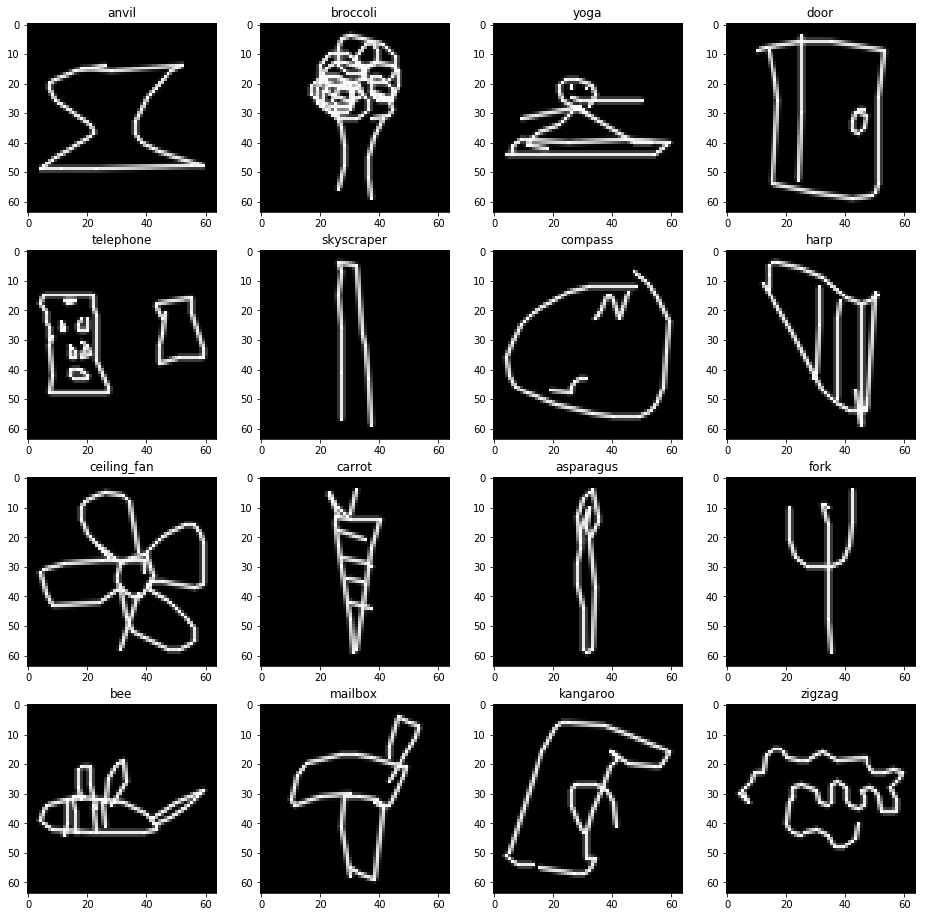

In [68]:
draw_a_batch()